# Example MLP: Data base German  Nummer

In this example it will show how to work the library **deepensemble**. 

## Data

This database corresponds to a problem of credit risk assessment seen as a classification problem where the classes correspond to whether the customer is good or bad. The database has 1000 samples, 700 (70%) to qualify as a good customer and 300 (30%) for bad clients. Each sample contains 24 characteristics that are normalized to the $ [0, 1] $ range. The original features are continuous and nominal with different amounts of categories.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from config_test import *

from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *


data_input, data_target, classes_labels, name_db, desc, col_names = \
    load_data('germannumer_scale', data_home='../../test_models/data', normalize=False)

# Generate testing and training sets
input_train, input_test, target_train, target_test = \
    model_selection.train_test_split(data_input, data_target, test_size=0.3)

## Define parameters of models and training

In [2]:
n_features = data_input.shape[1]
n_classes = len(classes_labels)

n_output = n_classes
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

n_ensemble_models = 4
fn_activation1 = ActivationFunctions.sigmoid
fn_activation2 = ActivationFunctions.sigmoid

y = get_index_label_classes(translate_target(data_target, classes_labels))
s = ITLFunctions.silverman(shared(np.array(y))).eval()

list_scores = [
    {'fun_score': mutual_information_parzen, 'name': 'Mutual Information'},
    {'fun_score': mutual_information_cs, 'name': 'QMI CS'},
    {'fun_score': mutual_information_ed, 'name': 'QMI ED'}
]

print('Silverman: %0.4g' % s)

batch_size = 32
max_epoch = 500

lr = 0.1

update_fn=sgd
name_update='SGD'

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 0.4523


## Training MLP MSE

This MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [3]:
# Create MLP
mlp = get_mlp_model("MLP MSE",
                    classification=True, classes_labels=classes_labels,
                    n_input=n_features, n_output=n_output,
                    n_neurons=n_neurons_model,
                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                    update=update_fn, name_update=name_update,
                    cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)
# Compile
mlp.compile(fast=True)                    
# training
metrics = mlp.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP MSE  - elapsed: 0.65 [s]
MLP MSE - fold: 1, epoch:[####################] 500/500 elapsed: 2.57[s] - left: 0.00[s] | score: 0.7845 / 0.7812
FINISHED!


<IPython.core.display.Javascript object>


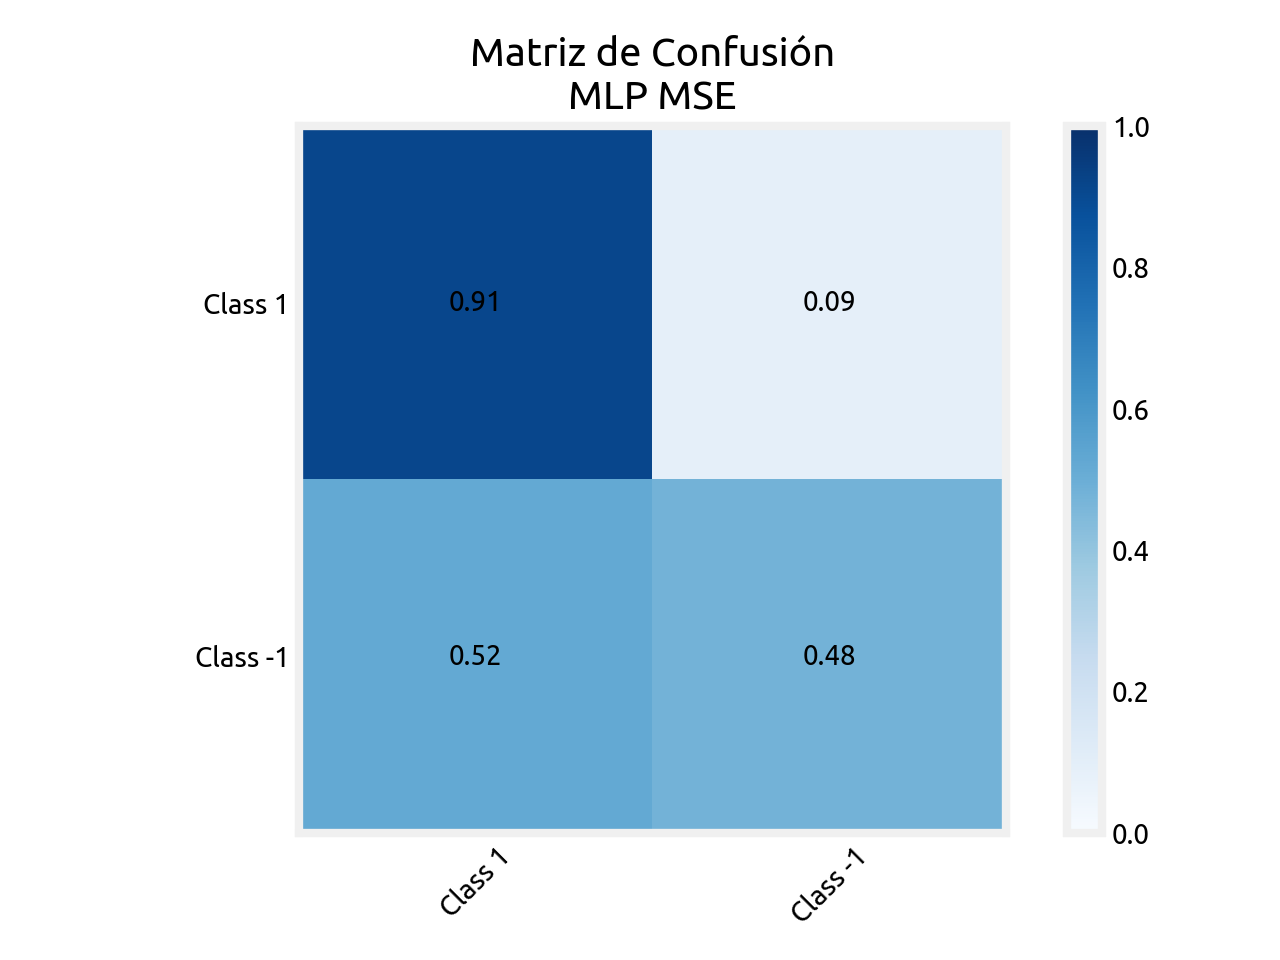

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    79.83 +-0.00      91.35 +-0.00      85.20 +-0.00      208               
Class -1   70.97 +-0.00      47.83 +-0.00      57.14 +-0.00      92                
----------------------------------------------------------------------------
average:   77.11 +-0.00      78.00 +-0.00      76.60 +-0.00      
----------------------------------------------------------------------------



In [4]:
metrics_mlp.append_prediction(input_test, target_test, append_last_pred=True)
metrics_mlp.plot_confusion_matrix(title='Matriz de Confusión\nMLP MSE')
plt.show()

metrics_mlp.classification_report()

## Training Ensemble MSE

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [5]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble MSE', classification=True, classes_labels=classes_labels,
                              n_input=n_features, n_output=n_output,
                              n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                              fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                              cost=mse, name_cost="MSE",
                              update=update_fn, name_update=name_update,
                              params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)
# Compile
ensemble.compile(fast=True)
# training
metrics = ensemble.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble MSE  - elapsed: 1.05 [s]
Ensamble MSE - fold: 1, epoch:[####################] 500/500 elapsed: 5.96[s] - left: 0.00[s] | score: 0.8010 / 0.7188
FINISHED!


<IPython.core.display.Javascript object>


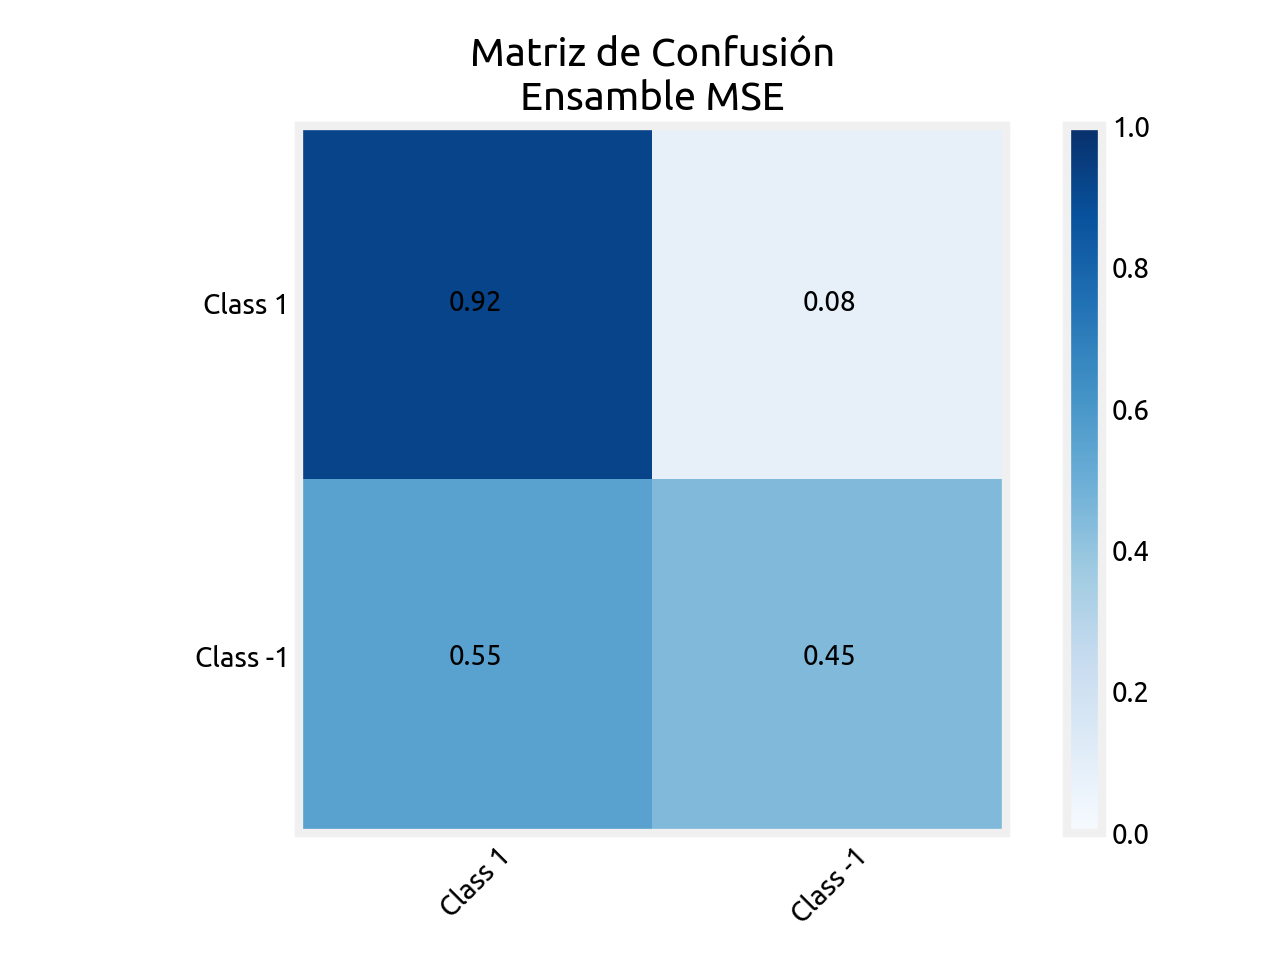

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    78.93 +-0.00      91.83 +-0.00      84.89 +-0.00      208               
Class -1   70.69 +-0.00      44.57 +-0.00      54.67 +-0.00      92                
----------------------------------------------------------------------------
average:   76.40 +-0.00      77.33 +-0.00      75.62 +-0.00      
----------------------------------------------------------------------------



In [6]:
metrics_ensemble.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensemble.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble MSE')
plt.show()

metrics_ensemble.classification_report()

<IPython.core.display.Javascript object>


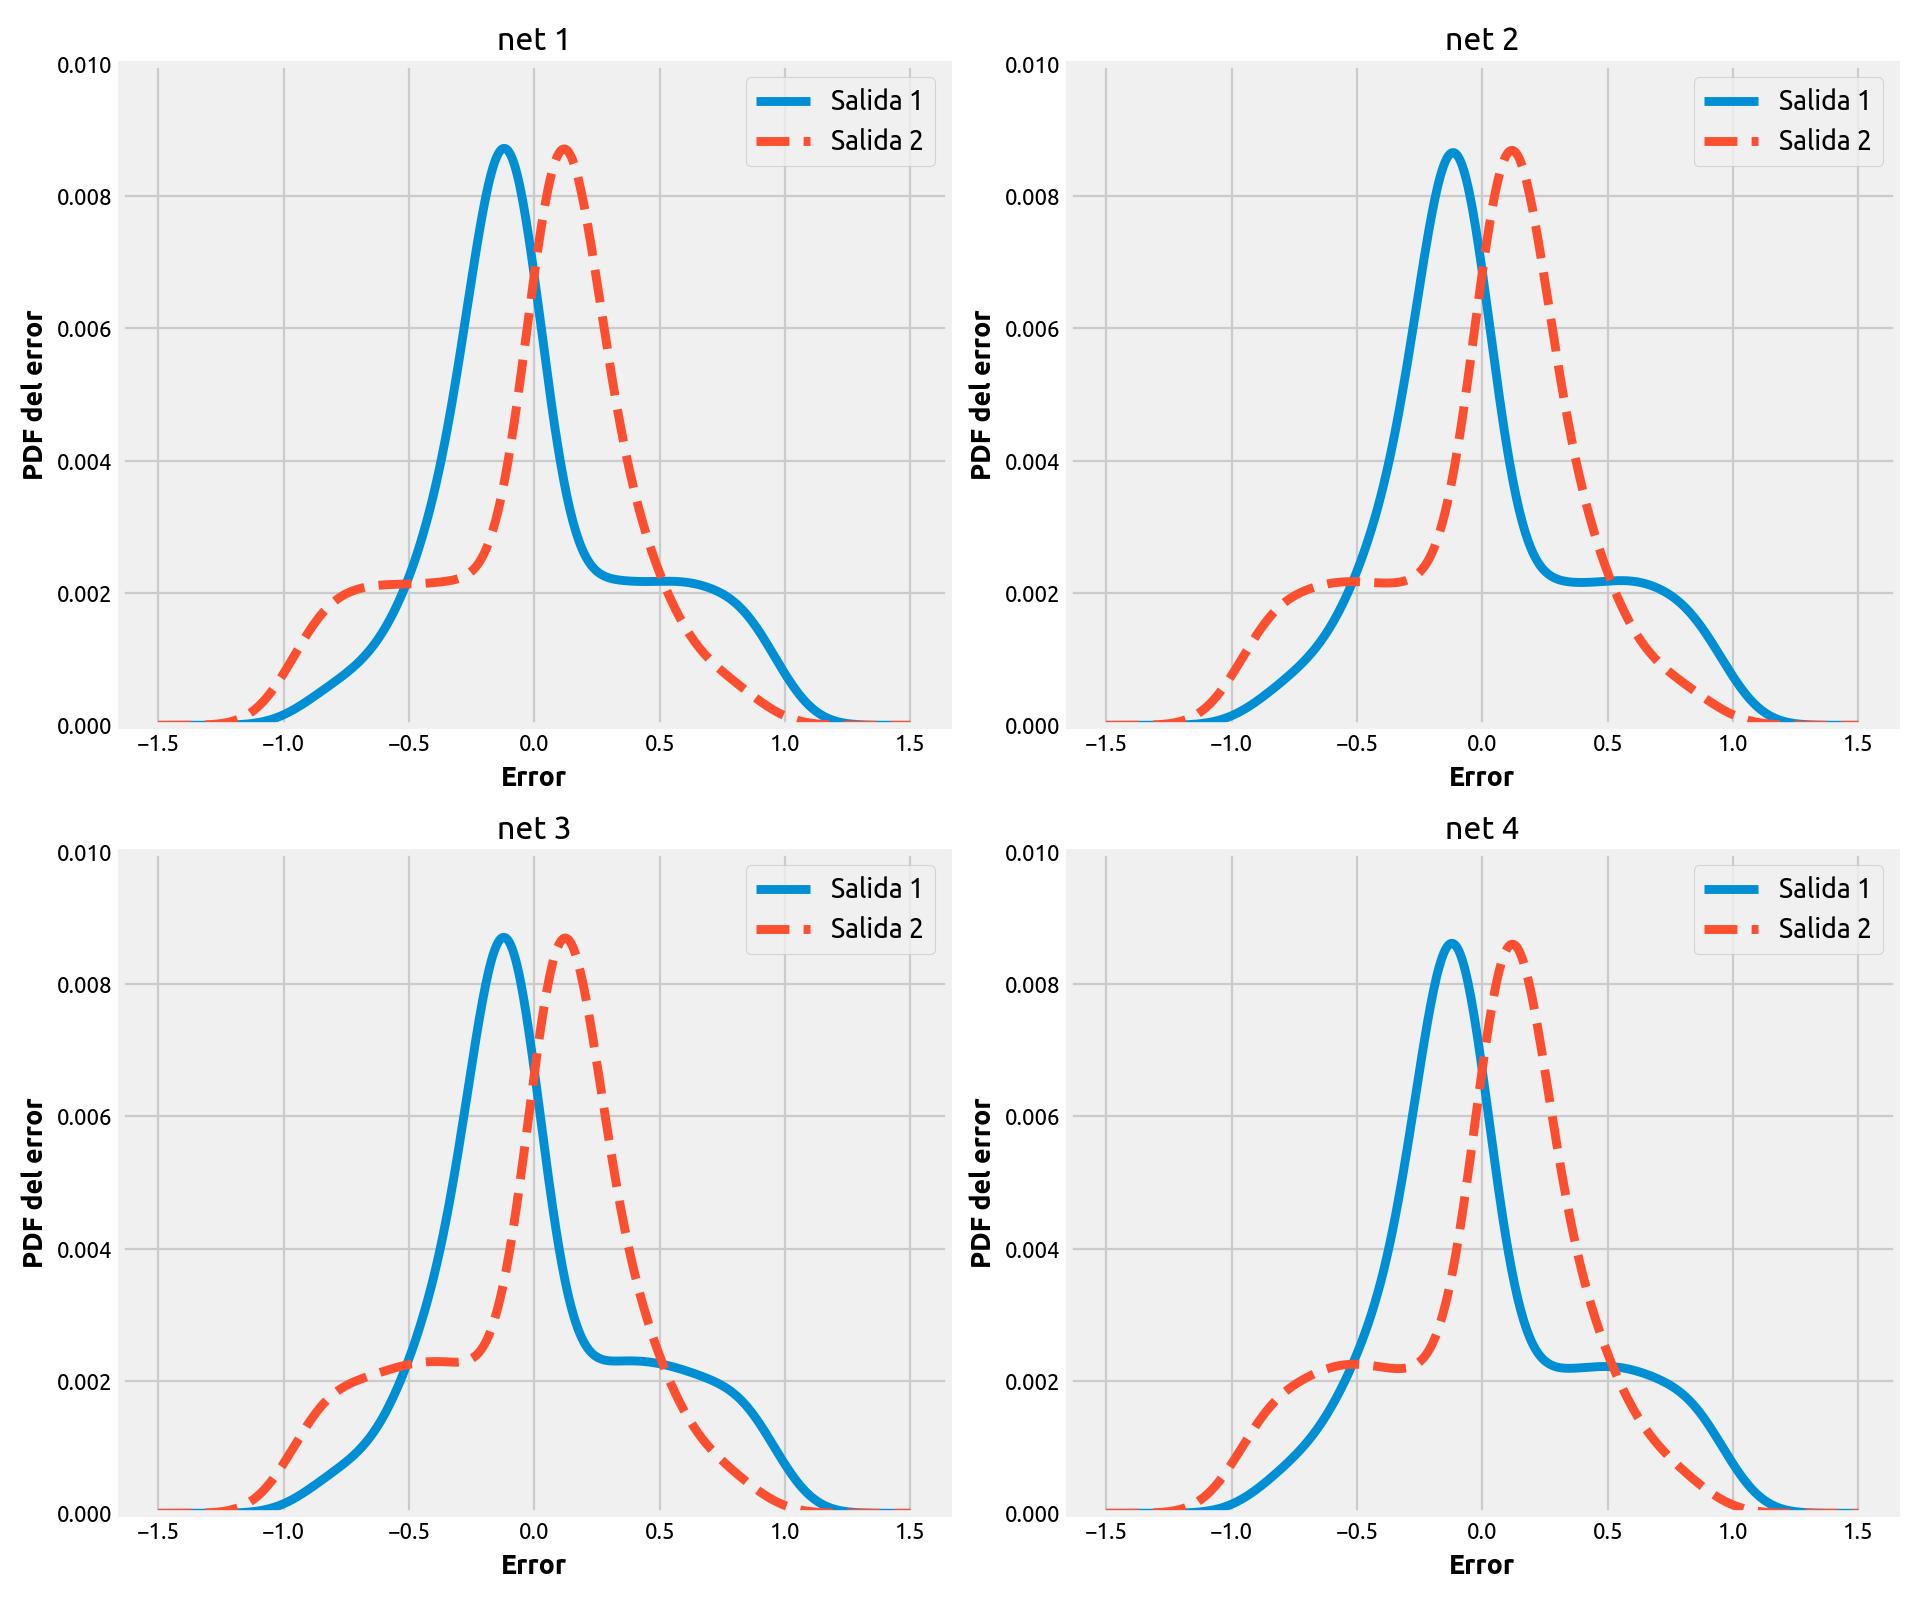

In [64]:
fig = plt.figure(figsize=(12, 5 * (n_ensemble_models // 2)), dpi=80)
for i in range(n_ensemble_models):
    ax = fig.add_subplot(n_ensemble_models // 2 + (n_ensemble_models % 2), 2, i + 1)
    plot_pdf_error(ensemble.get_models()[i], input_test, target_test, 'net %d' % (i + 1), ax, fig, lim_y=0.01)

## Training Ensemble NCL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **NCL** (Negative Correlation Learning) and the update funtion is **SGD** (learning rate $\eta=${{lr}}). The parameter of **NCL** is $\lambda=0.8$.

In [53]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL', classification=True, classes_labels=classes_labels,
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        update=update_fn, name_update=name_update,
                                        lamb=0.8, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)
# Compile
ensembleNCL.compile(fast=True)                 
# training
metrics = ensembleNCL.fit(input_train, target_train, **args_train_default)
print("FINISHED!")
# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 3.41 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 10.92[s] - left: 0.00[s] | score: 0.7911 / 0.7031
FINISHED!


<IPython.core.display.Javascript object>


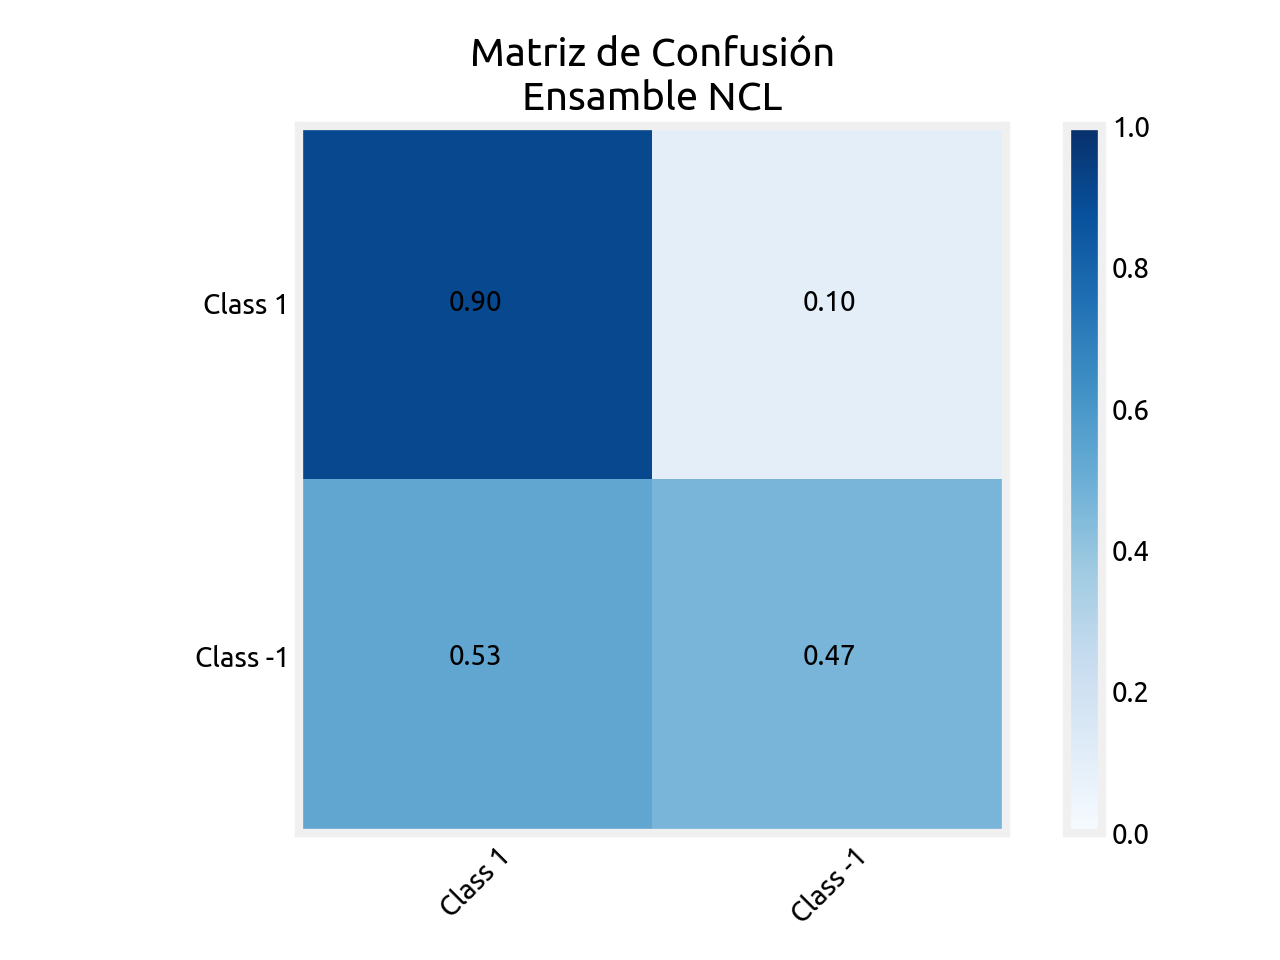

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    79.32 +-0.00      90.38 +-0.00      84.49 +-0.00      208               
Class -1   68.25 +-0.00      46.74 +-0.00      55.48 +-0.00      92                
----------------------------------------------------------------------------
average:   75.93 +-0.00      77.00 +-0.00      75.60 +-0.00      
----------------------------------------------------------------------------



In [54]:
metrics_ensembleNCL.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleNCL.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble NCL')
plt.show()

metrics_ensembleNCL.classification_report()

<IPython.core.display.Javascript object>


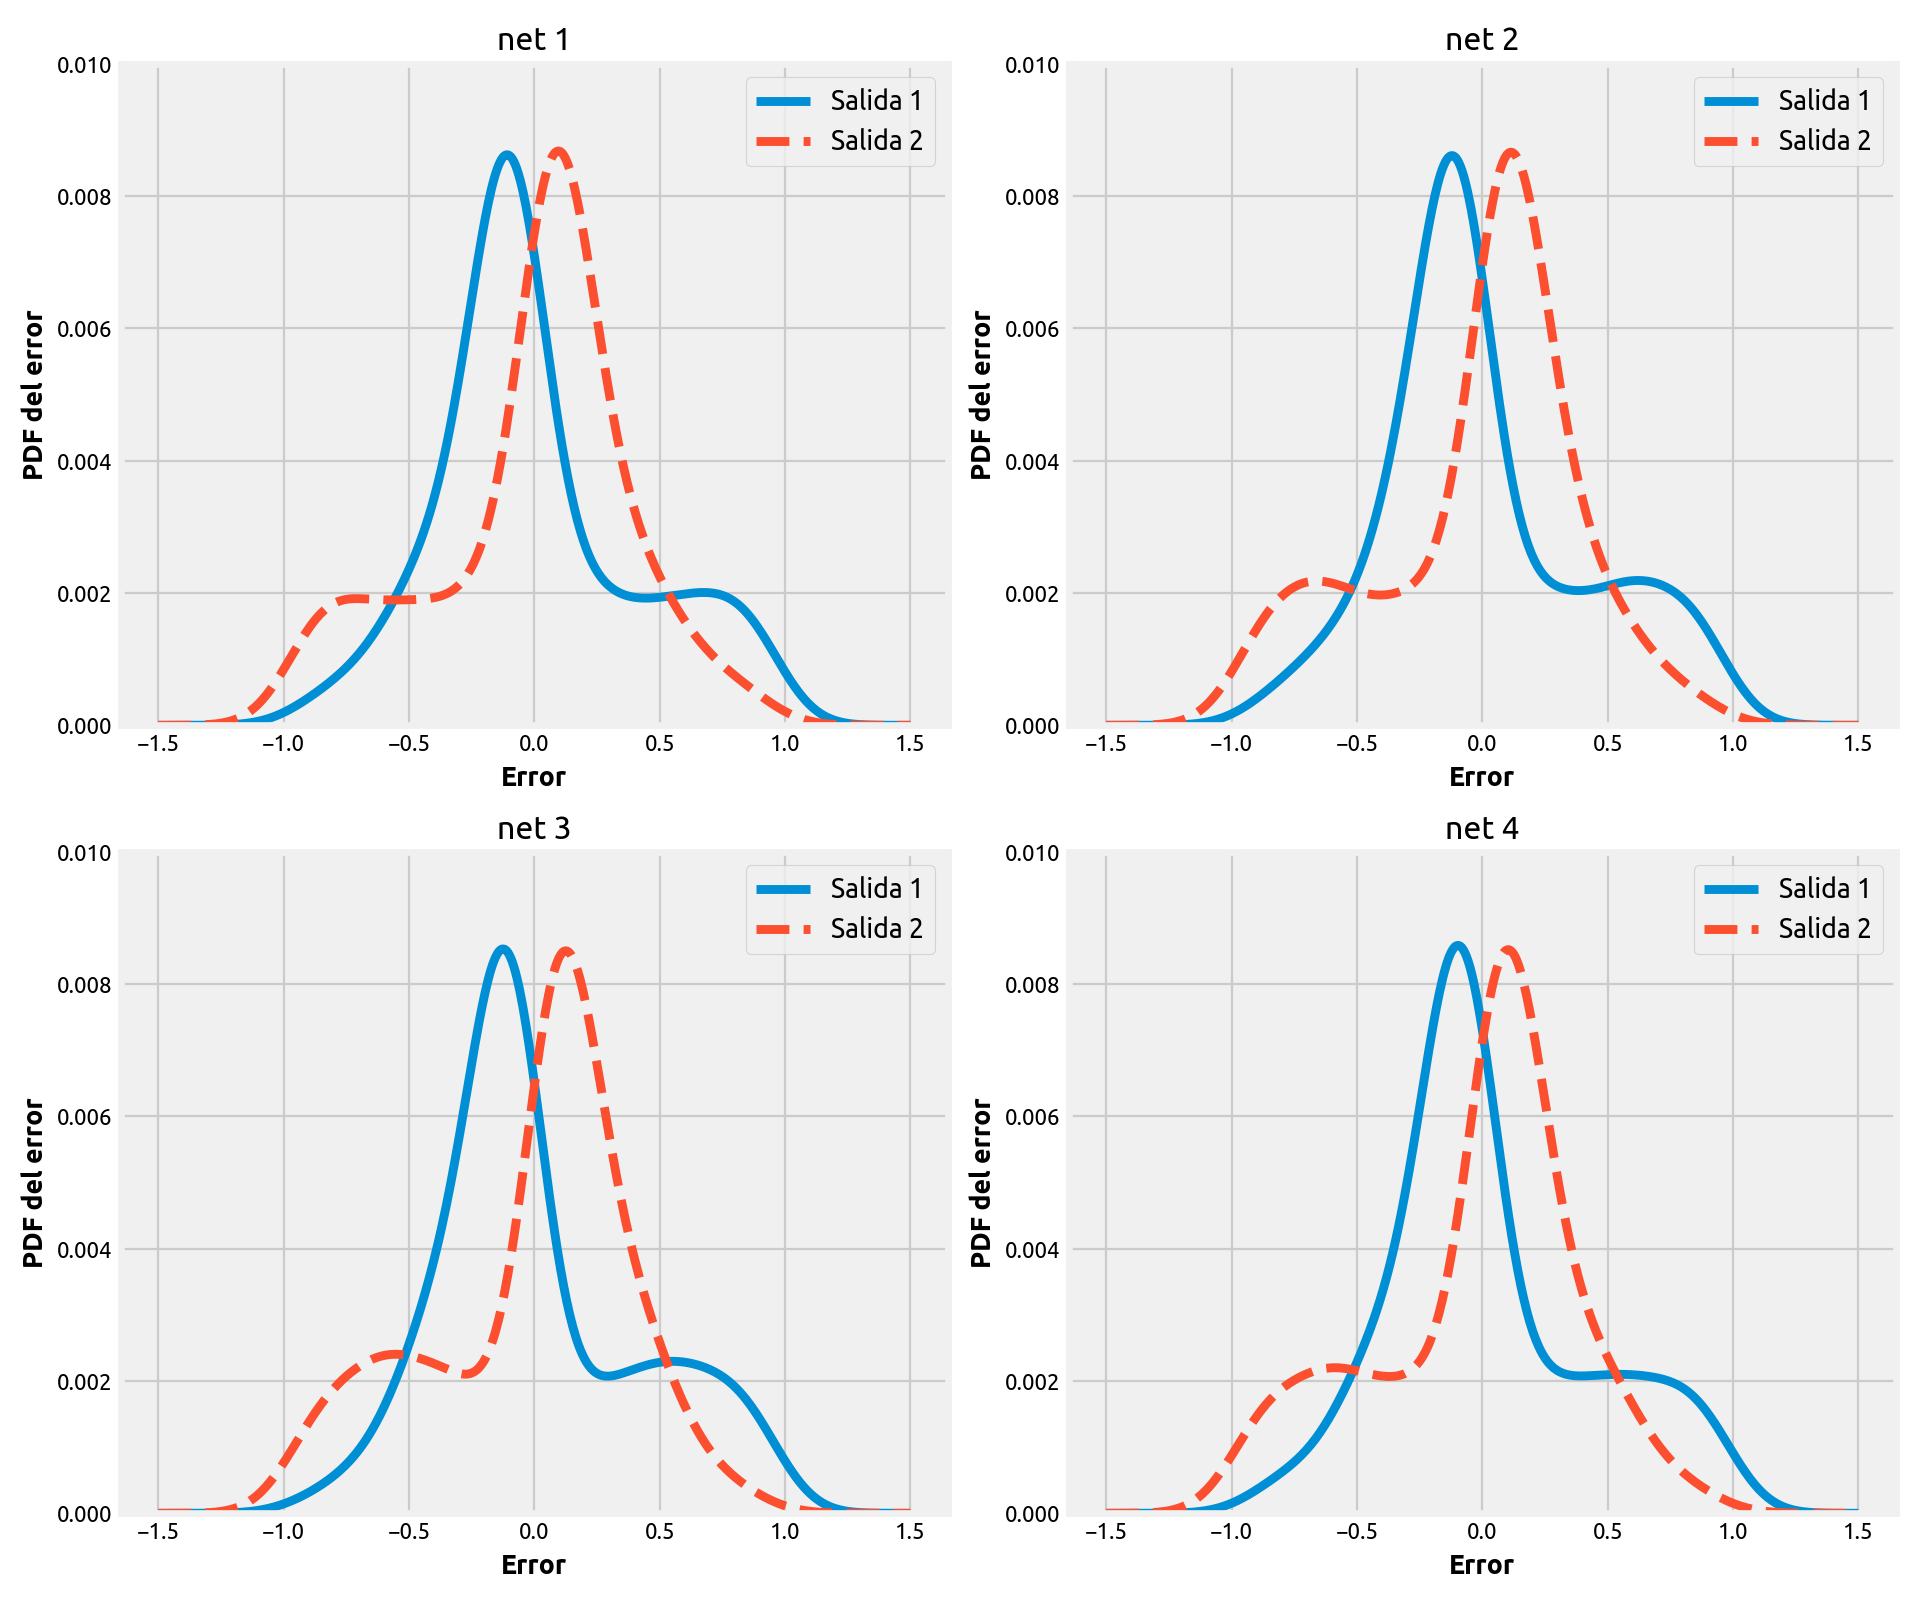

In [63]:
fig = plt.figure(figsize=(12, 5 * (n_ensemble_models // 2)), dpi=80)
for i in range(n_ensemble_models):
    ax = fig.add_subplot(n_ensemble_models // 2 + (n_ensemble_models % 2), 2, i + 1)
    plot_pdf_error(ensembleNCL.get_models()[i], input_test, target_test, 'net %d' % (i + 1), ax, fig, lim_y=0.01)

## Training Ensemble CIPL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer and the output is a vector with {{n_output}} elements that represent each class (**one hot encoding**). The cost function is **CIPL** (Cross Informartion Potential Learning) and the update funtion is **SGD** (learning rate $\eta=-0.2$). The parameters of **CIPL** are $\beta=0.1$ and $\lambda=0.5$.

In [47]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL', classification=True, classes_labels=classes_labels,
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.1, lamb=0.5, s=s,
                                    lsp=2.0, lsm=0.8,
                                    lr=0.001,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=update_fn, name_update=name_update,
                                    params_update={'learning_rate': -0.2})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)
# Compile
ensembleCIP.compile(fast=False)                   
# training
metrics = ensembleCIP.fit(input_train, target_train, **args_train_cip)
print("FINISHED!")
# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 18.24 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 46.91[s] - left: 0.00[s] | score: 0.7862 / 0.76569
FINISHED!


<IPython.core.display.Javascript object>


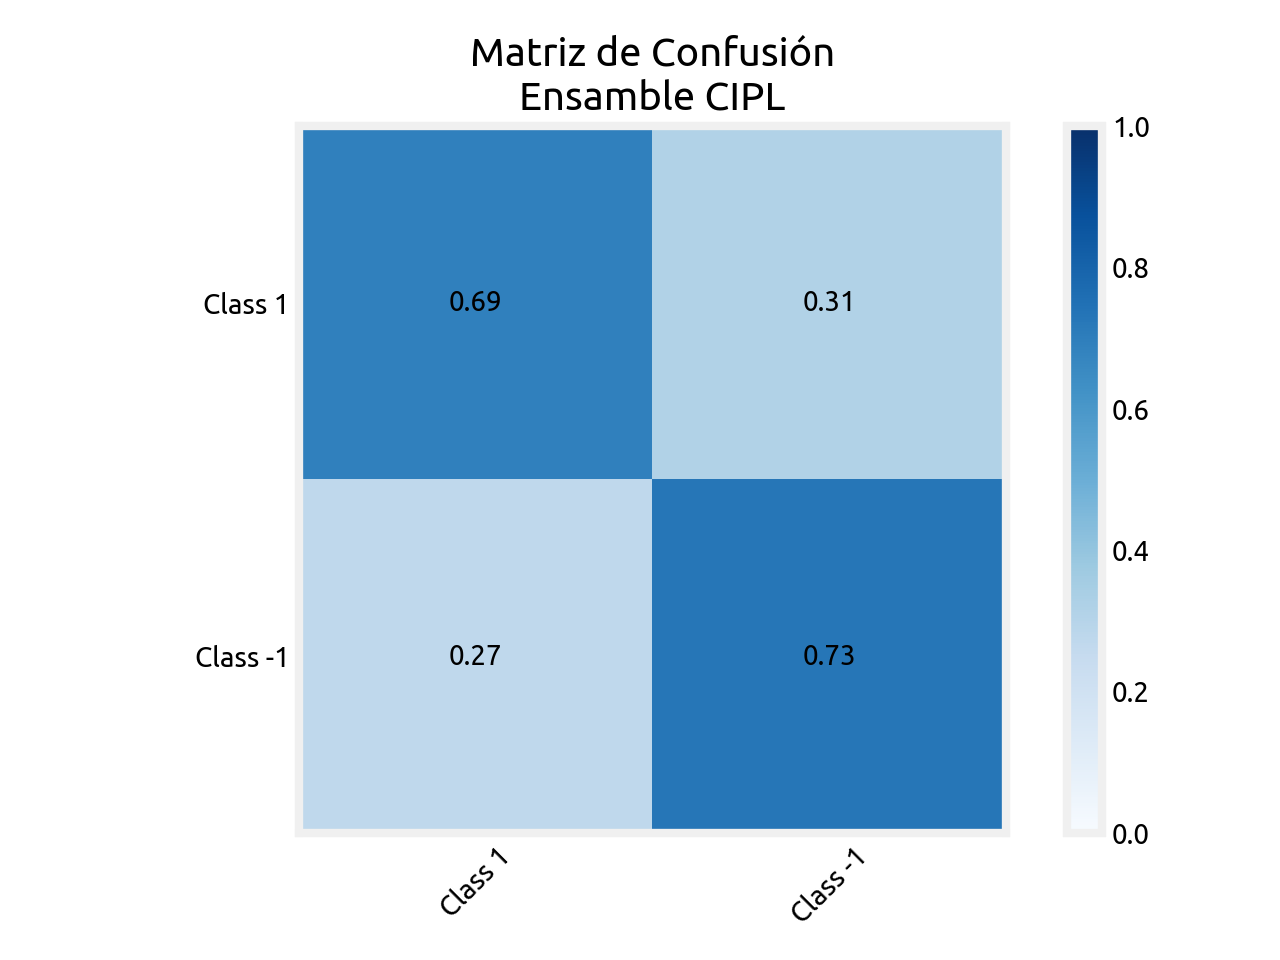

Classification Report:
----------------------------------------------------------------------------
           Precision  Recall     f1 Score   Support    
----------------------------------------------------------------------------
Class 1    85.12 +-0.00      68.75 +-0.00      76.06 +-0.00      208               
Class -1   50.76 +-0.00      72.83 +-0.00      59.82 +-0.00      92                
----------------------------------------------------------------------------
average:   74.58 +-0.00      70.00 +-0.00      71.08 +-0.00      
----------------------------------------------------------------------------



In [48]:
metrics_ensembleCIP.append_prediction(input_test, target_test, append_last_pred=True)
metrics_ensembleCIP.plot_confusion_matrix(title='Matriz de Confusión\nEnsamble CIPL')
plt.show()

metrics_ensembleCIP.classification_report()

## Plot Scores ans cost functions of Ensemble CIPL training

<IPython.core.display.Javascript object>


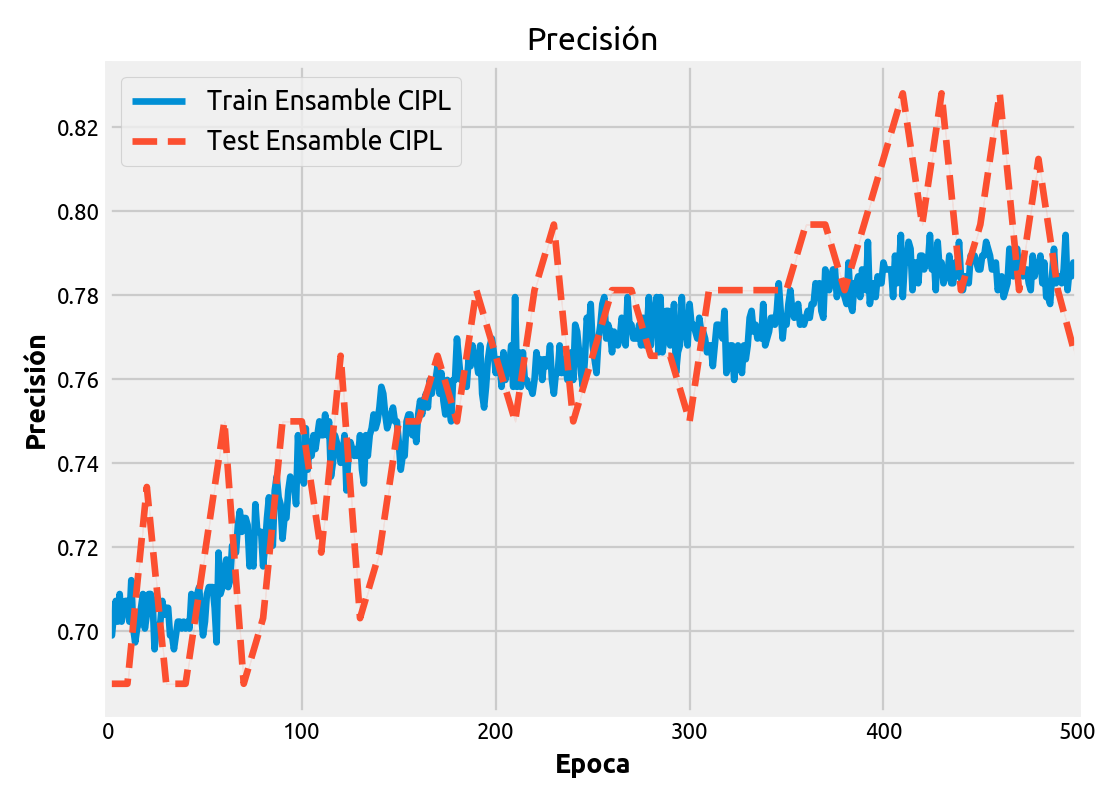

<IPython.core.display.Javascript object>


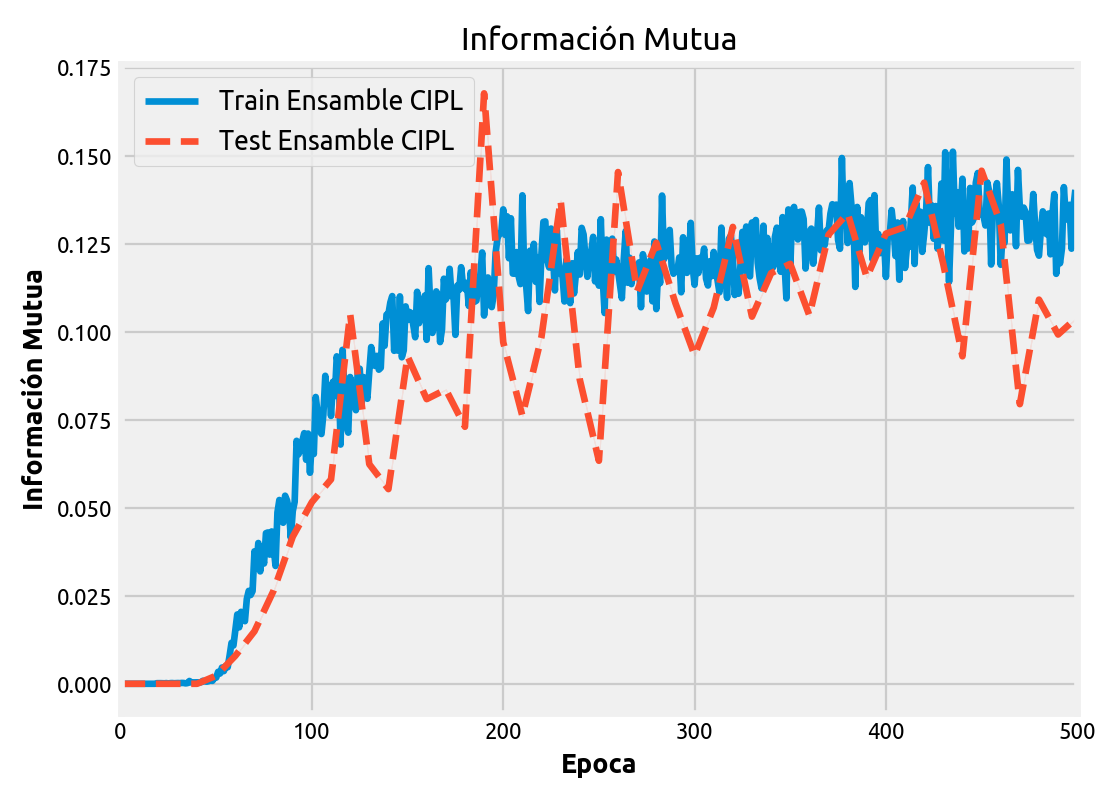

<IPython.core.display.Javascript object>


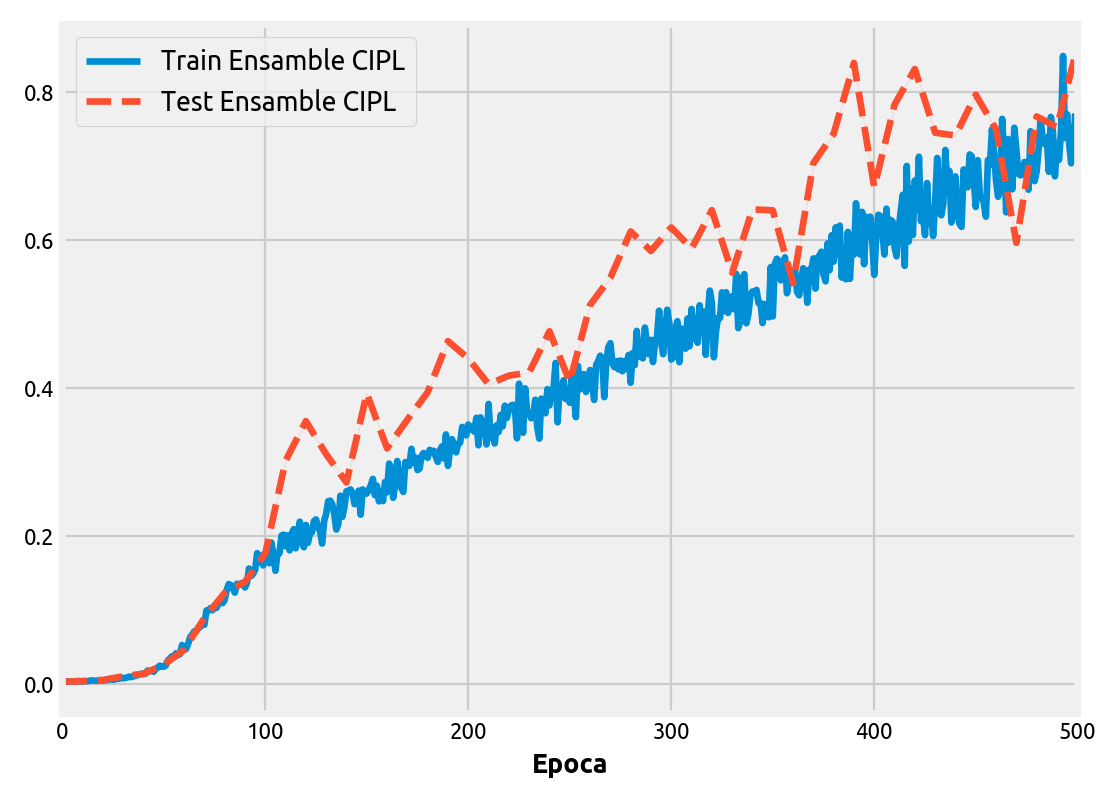

In [49]:
metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='')

plt.show()

<IPython.core.display.Javascript object>


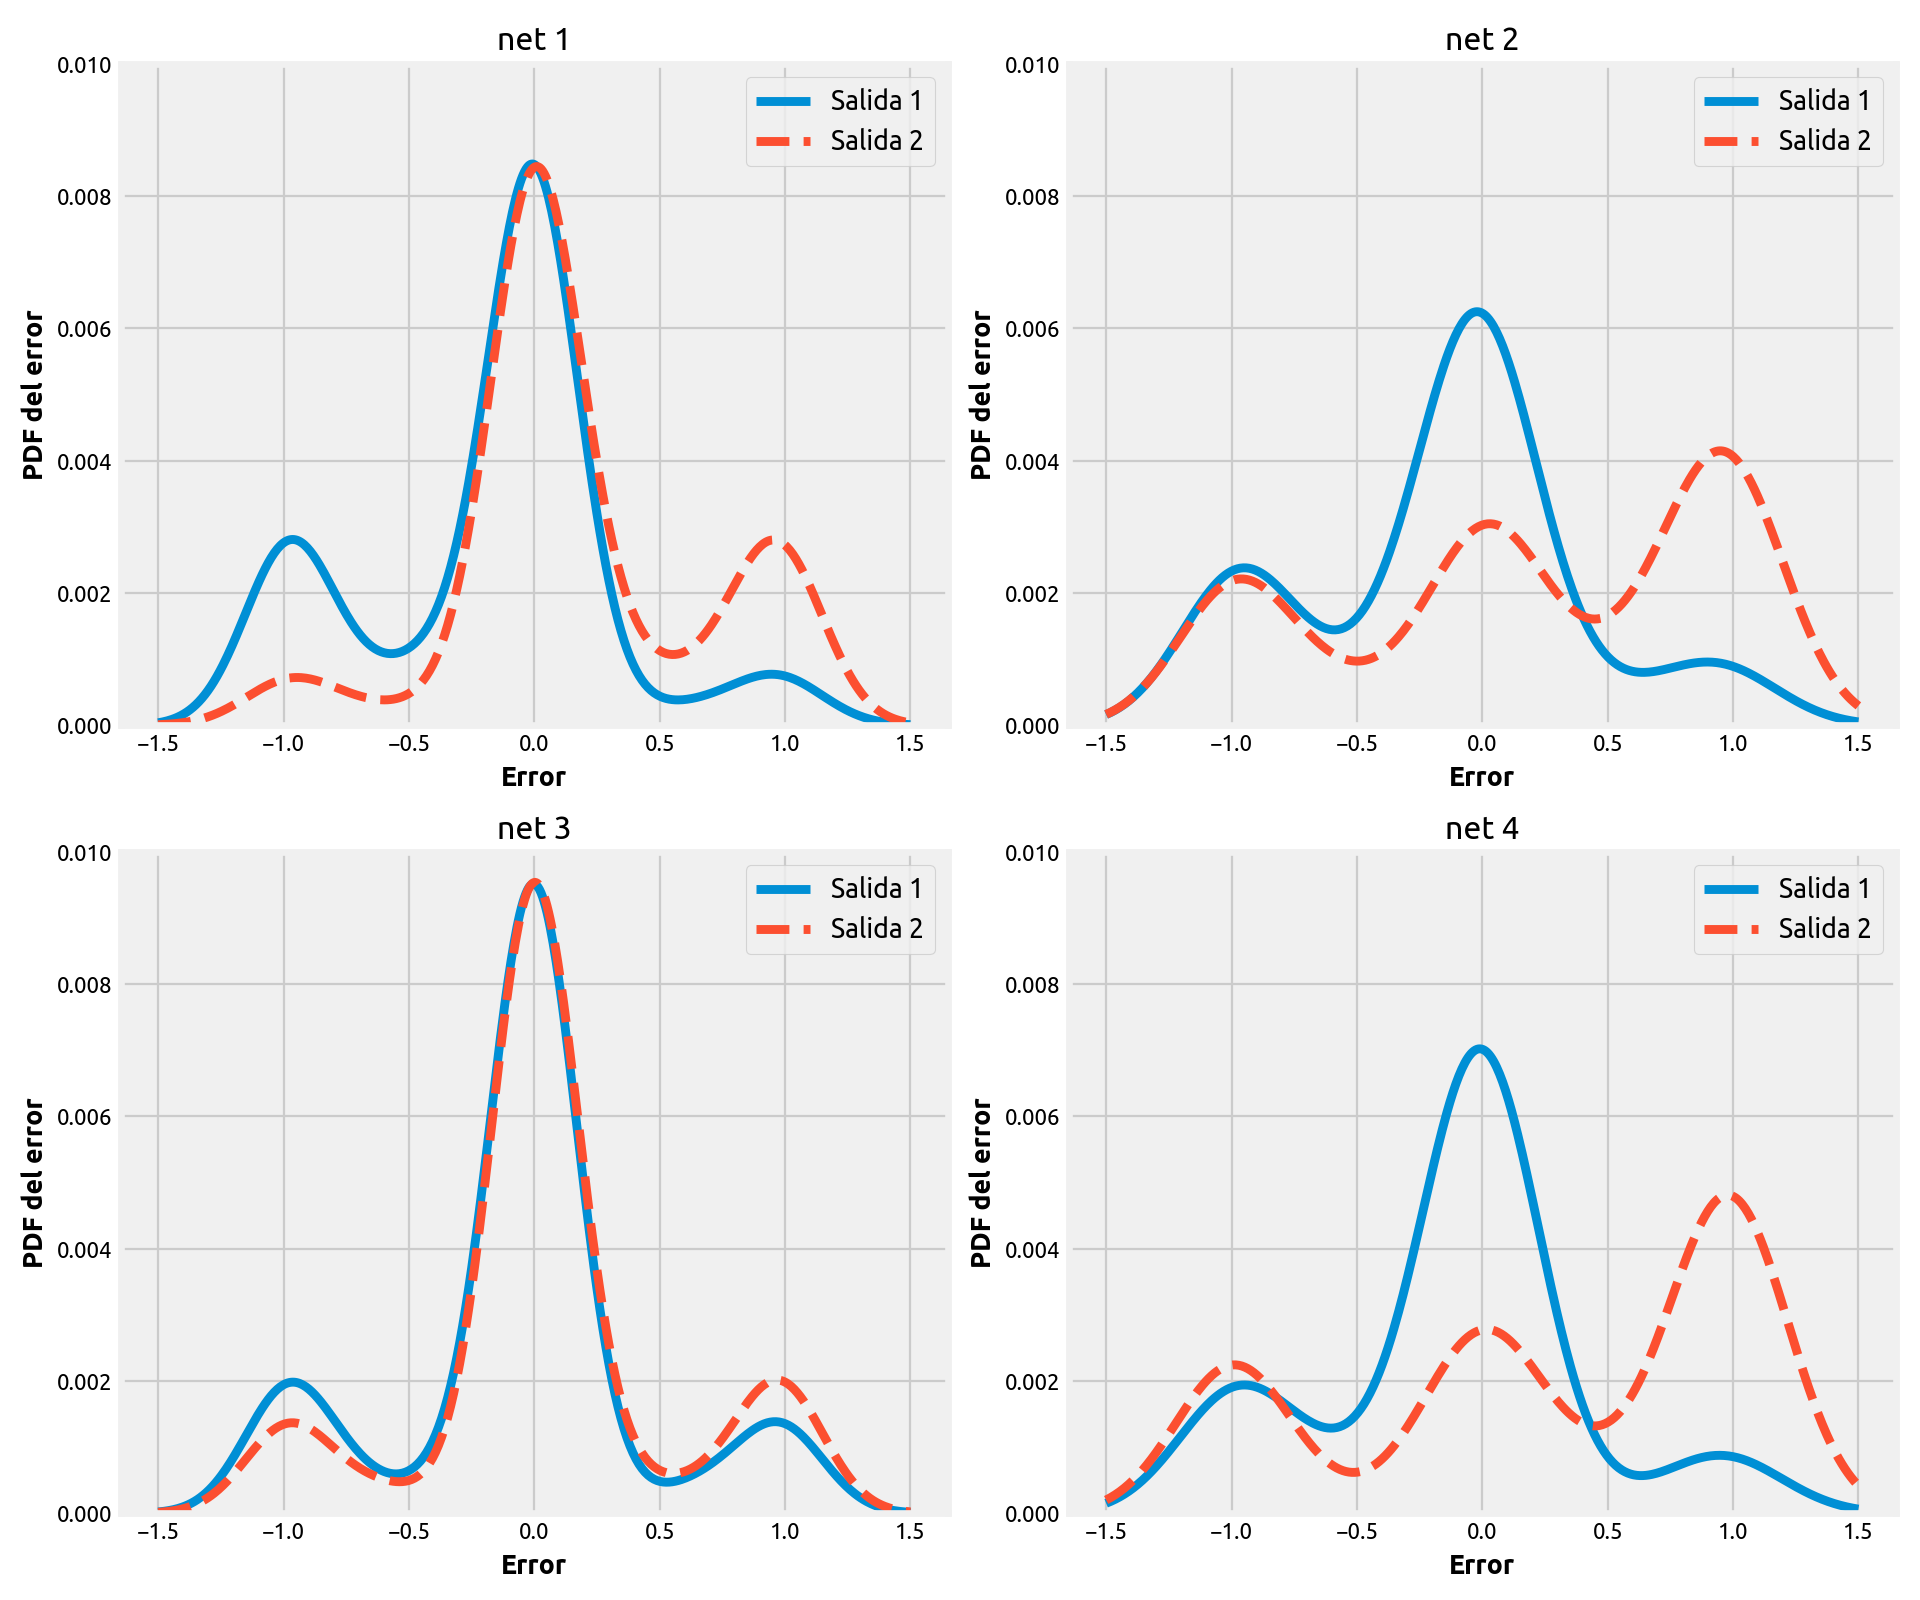

In [61]:
fig = plt.figure(figsize=(12, 5 * (n_ensemble_models // 2)), dpi=80)
for i in range(n_ensemble_models):
    ax = fig.add_subplot(n_ensemble_models // 2 + (n_ensemble_models % 2), 2, i + 1)
    plot_pdf_error(ensembleCIP.get_models()[i], input_test, target_test, 'net %d' % (i + 1), ax, fig, lim_y=0.01)

## Summary training

In [50]:
score_test_ensemble = ensemble.score(input_test, target_test)
score_train_ensemble = ensemble.score(input_train, target_train)

score_test_ensembleNCL = ensembleNCL.score(input_test, target_test)
score_train_ensembleNCL = ensembleNCL.score(input_train, target_train)

score_test_ensembleCIP = ensembleCIP.score(input_test, target_test)
score_train_ensembleCIP = ensembleCIP.score(input_train, target_train)

score_test_mlp = mlp.score(input_test, target_test)
score_train_mlp = mlp.score(input_train, target_train)

print('Score Precisión')
print('Ensamble MSE: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP MSE: %f / %f' % (score_train_mlp, score_test_mlp))

Score Precisión
Ensamble MSE: 0.784286 / 0.773333
Ensamble NCL: 0.788571 / 0.780000
Ensamble CIP: 0.741429 / 0.700000
MLP MSE: 0.787143 / 0.780000


## Plot PDF Error for each model training

### Training set

<IPython.core.display.Javascript object>


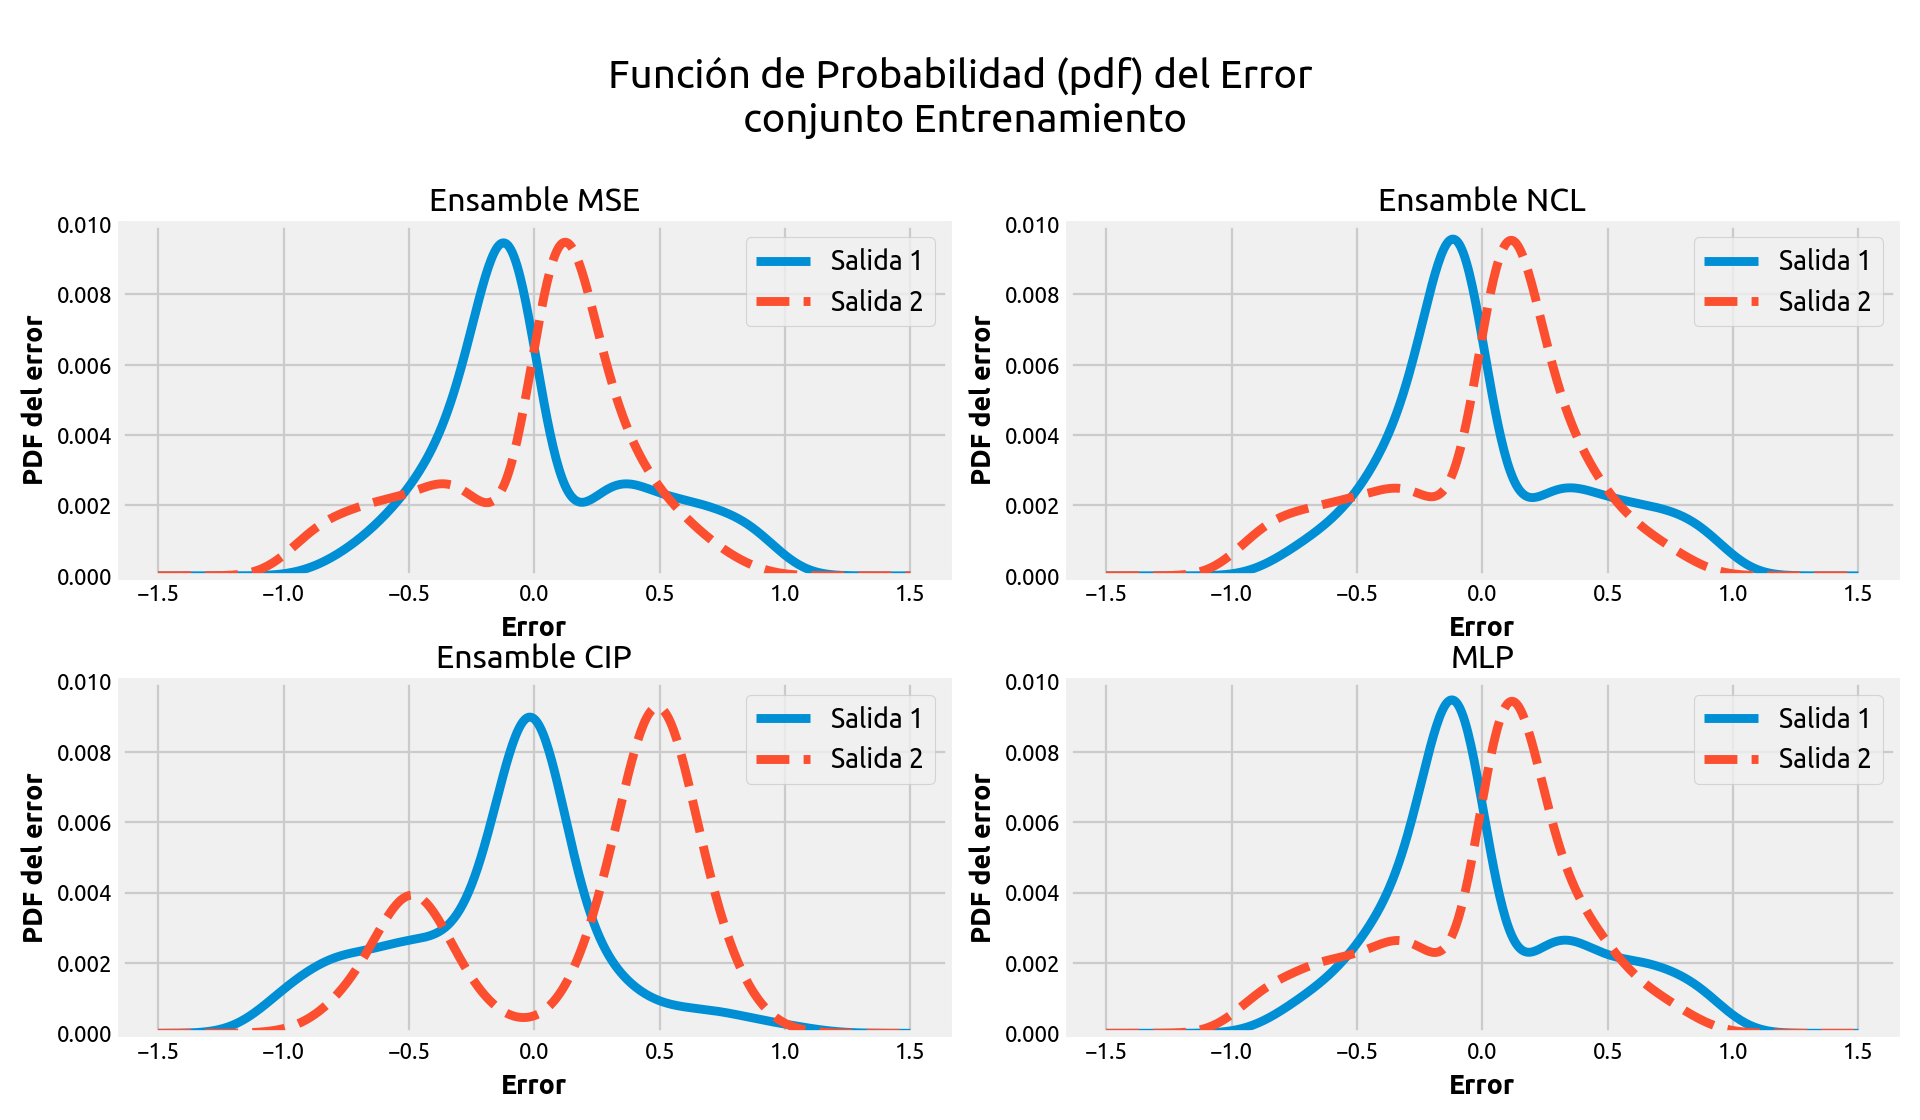

In [55]:
fig = plt.figure(figsize=(12, 7), dpi=80)
lim_y = 0.01

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_train, target_train, 'Ensamble MSE', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_train, target_train, 'Ensamble NCL', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_train, target_train, 'Ensamble CIP', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_train, target_train, 'MLP', ax, fig, lim_y=lim_y)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)


### Test set

<IPython.core.display.Javascript object>


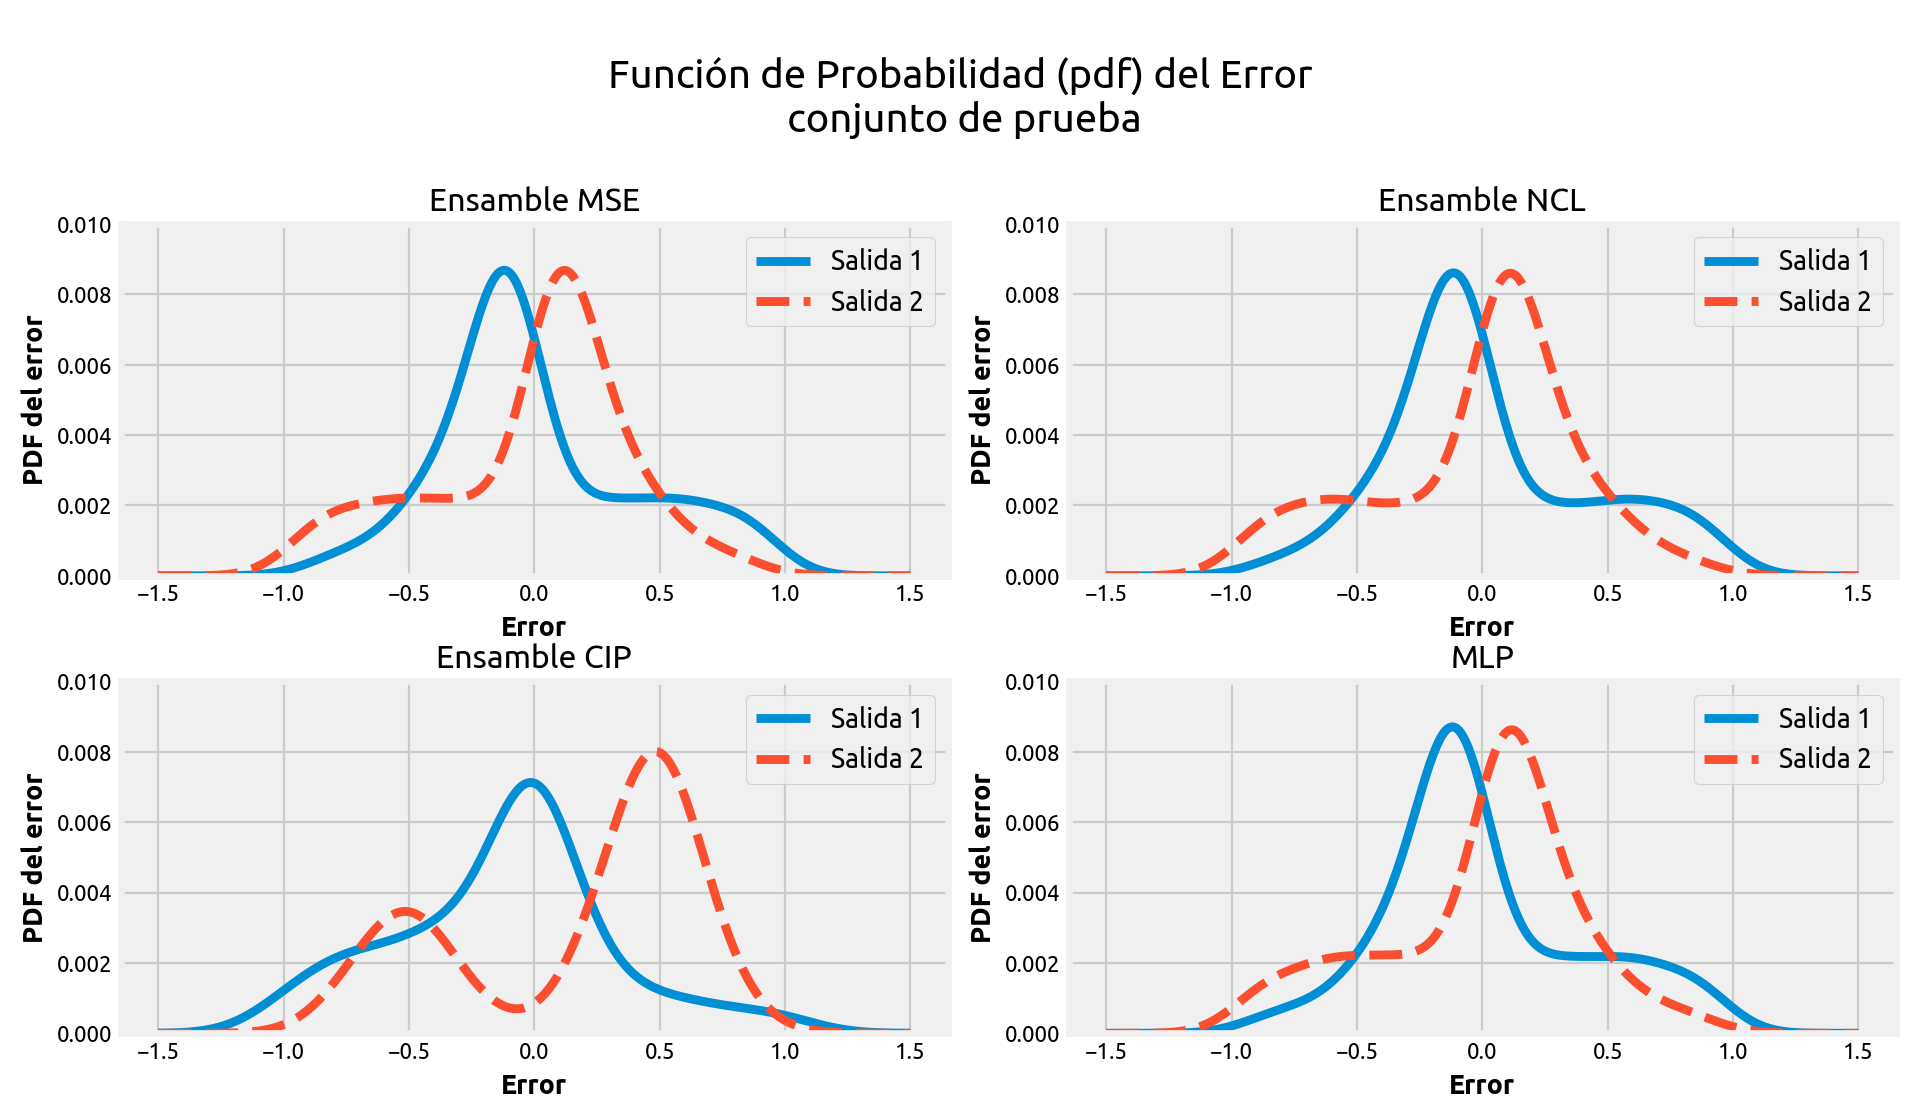

In [56]:
fig = plt.figure(figsize=(12, 7), dpi=80)

ax = fig.add_subplot(2, 2, 1)
plot_pdf_error(ensemble, input_test, target_test, 'Ensamble MSE', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 2)
plot_pdf_error(ensembleNCL, input_test, target_test, 'Ensamble NCL', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 3)
plot_pdf_error(ensembleCIP, input_test, target_test, 'Ensamble CIP', ax, fig, lim_y=lim_y)

ax = fig.add_subplot(2, 2, 4)
plot_pdf_error(mlp, input_test, target_test, 'MLP', ax, fig, lim_y=lim_y)

st = fig.suptitle("Función de Probabilidad (pdf) del Error\n conjunto de prueba", fontsize=18)

st.set_y(0.95)
fig.subplots_adjust(top=0.8)

plt.show()

## Test: Prediction with noise in input data

In [57]:
def get_ensemble_cip_cs(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=2.0, lsm=0.8,
                                    lr=0.01,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.2}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_ed(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    classification=True,
                                    is_cip_full=False,
                                    classes_labels=classes_labels,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lsp=2.0, lsm=0.8,
                                    lr=0.01,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=True,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.2}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [66]:
model_cs = get_ensemble_cip_cs(0.1, s)
model_cs.fit(input_train, target_train, **args_train_cip)

Comienza la compilación Ensamble CIPL CS  - elapsed: 18.43 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 34.80[s] - left: 0.00[s] | score: 0.7961 / 0.79691


In [65]:
model_ed = get_ensemble_cip_ed(0.1, s)
model_ed.fit(input_train, target_train, **args_train_cip)

Comienza la compilación Ensamble CIPL ED  - elapsed: 16.20 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 32.41[s] - left: 0.00[s] | score: 0.7500 / 0.70318


In [67]:
noise = [n for n in np.linspace(0.01, 1, 10)]
score_snr_cs = []
score_snr_ed = []
score_snr_ncl = []
score_snr_en = []
score_snr_mlp = []
SNR = []
N = input_test.shape[0]
F = input_test.shape[1]
mu = 0.2

for n in noise:
    ne = np.random.randn(N, F) * n + mu
    z = input_test + ne
    score_snr_cs.append(model_cs.score(z, target_test))
    score_snr_ed.append(model_ed.score(z, target_test))
    score_snr_ncl.append(ensembleNCL.score(z, target_test))
    score_snr_en.append(ensemble.score(z, target_test))
    score_snr_mlp.append(mlp.score(z, target_test))
    SNR.append(np.var(input_test) / np.var(ne))

<IPython.core.display.Javascript object>


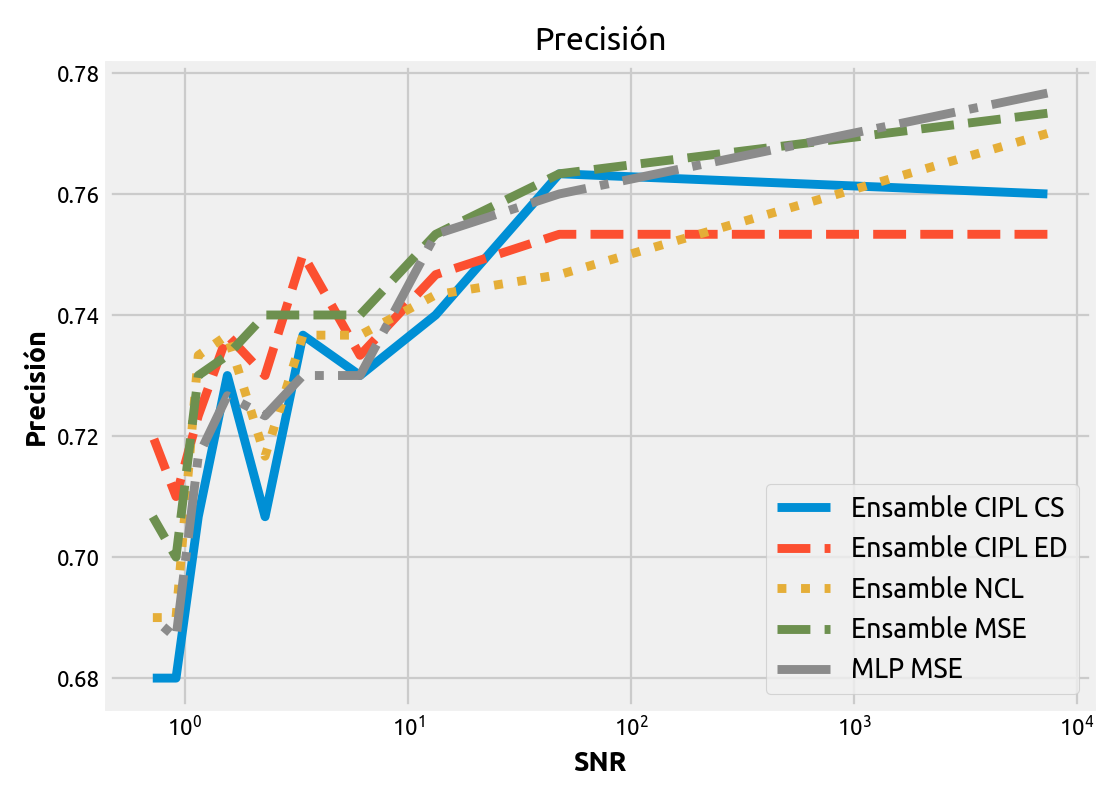

In [68]:
f = plt.figure(figsize=(7,5), dpi=80)
plt.plot(SNR, score_snr_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(SNR, score_snr_ed, linestyle='--', label='Ensamble CIPL ED')
plt.plot(SNR, score_snr_ncl, linestyle=':', label='Ensamble NCL')
plt.plot(SNR, score_snr_en, linestyle='--', label='Ensamble MSE')
plt.plot(SNR, score_snr_mlp, linestyle='-.', label='MLP MSE')
plt.xscale('log')
plt.legend(loc='best')
plt.title('Precisión')
plt.xlabel('SNR')
plt.ylabel('Precisión')
plt.tight_layout()

plt.show()

## Test: Diversity of Ensemble CIPL when changes parameters $\beta$ and $\lambda$.

In this test is used CIPL with Cauchy-Schwarz and Euclidean divergency. The diversity is measured with:

- Kohavi wolpert Variance.
- Generalized Diversity.
- Coincident Failure.
- Entropy sk.
- Difficulty.

In [18]:
parameters = [n for n in np.linspace(-1, 1, 11)]

score_cs = []
diversity_cs = []
for p in parameters:
    model_cs = get_ensemble_cip_cs(p, s)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_cs.fit(input_train, target_train, **args_train_cip)
        metric.append_prediction(input_test, target_test, append_last_pred=True)
        score.append(model_cs.score(input_test, target_test))
        divty.append(metric.get_diversity(metric=generalized_diversity)[0])
        model_cs.reset()
    
    score_cs.append( [np.mean(score), np.std(score)] )
    diversity_cs.append( [np.mean(divty), np.std(divty)] )

Comienza la compilación Ensamble CIPL CS  - elapsed: 14.85 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.27 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.96 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 14.89 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.76 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 2.14 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 15.90 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 17.20 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 13.98 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.50 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 17.88 [s]


In [69]:
score_ed = []
diversity_ed = []
for p in parameters:
    model_ed = get_ensemble_cip_ed(p, s)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_ed.fit(input_train, target_train, **args_train_cip)
        metric.append_prediction(input_test, target_test, append_last_pred=True)
        score.append(model_ed.score(input_test, target_test))
        divty.append(metric.get_diversity(metric=generalized_diversity)[0])
        model_ed.reset()
    
    score_ed.append( [np.mean(score), np.std(score)] )
    diversity_ed.append( [np.mean(divty), np.std(divty)]  )

Comienza la compilación Ensamble CIPL ED  - elapsed: 17.62 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 19.76 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 22.62 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 20.21 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 18.47 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 2.68 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 19.85 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 19.49 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 22.55 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 19.93 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 22.37 [s]


<IPython.core.display.Javascript object>


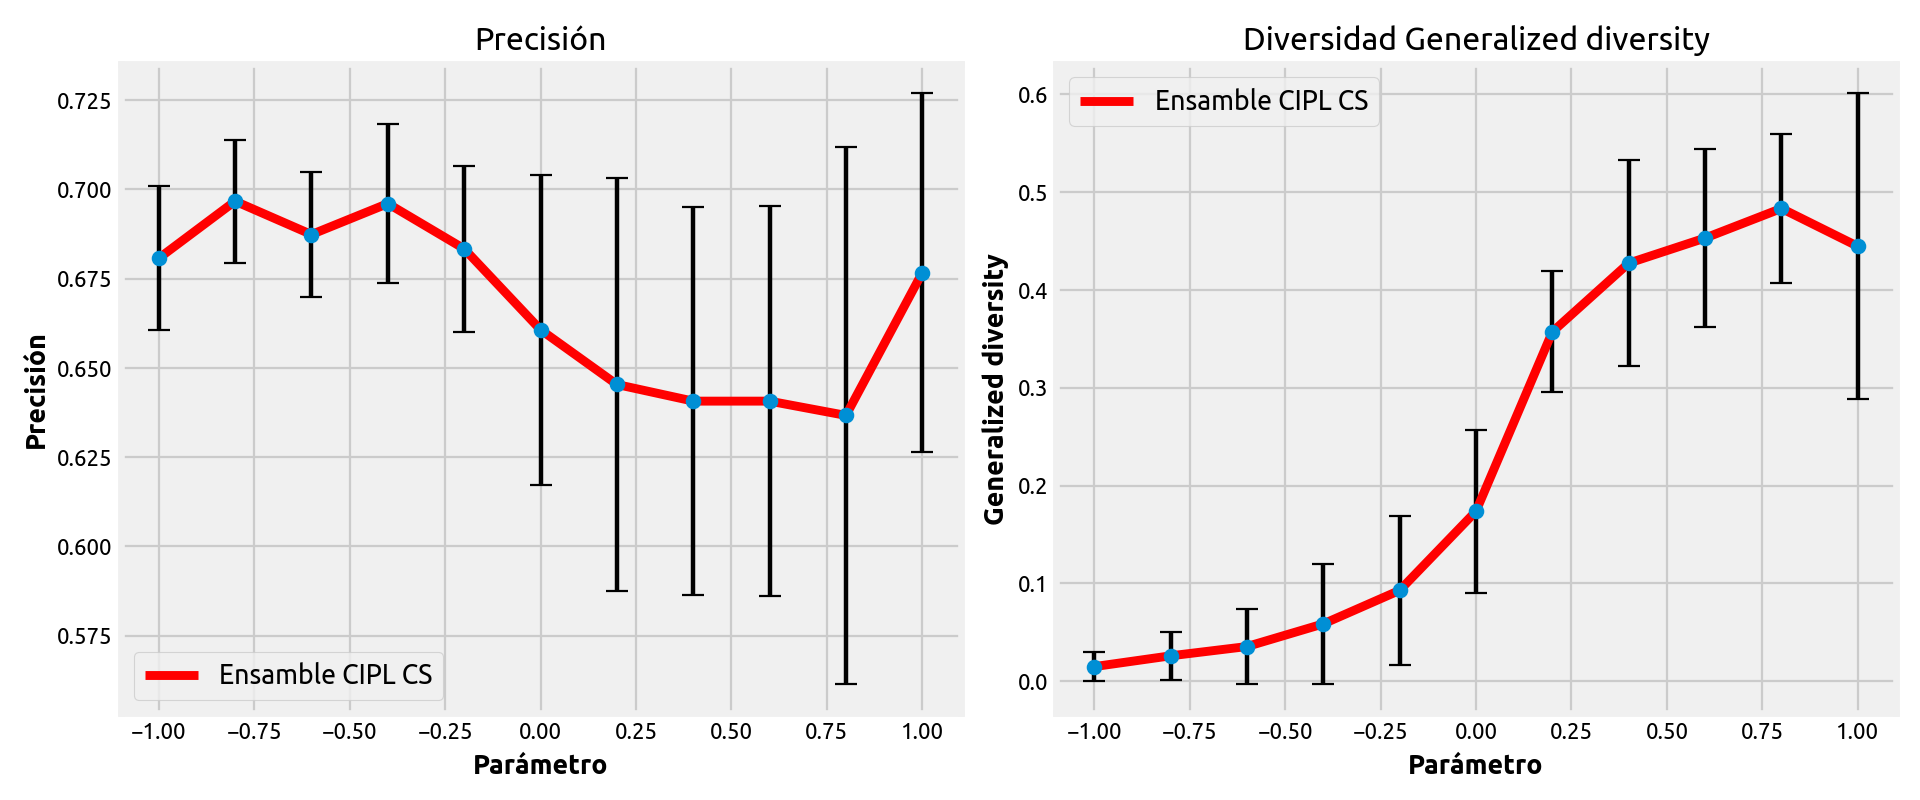

<IPython.core.display.Javascript object>


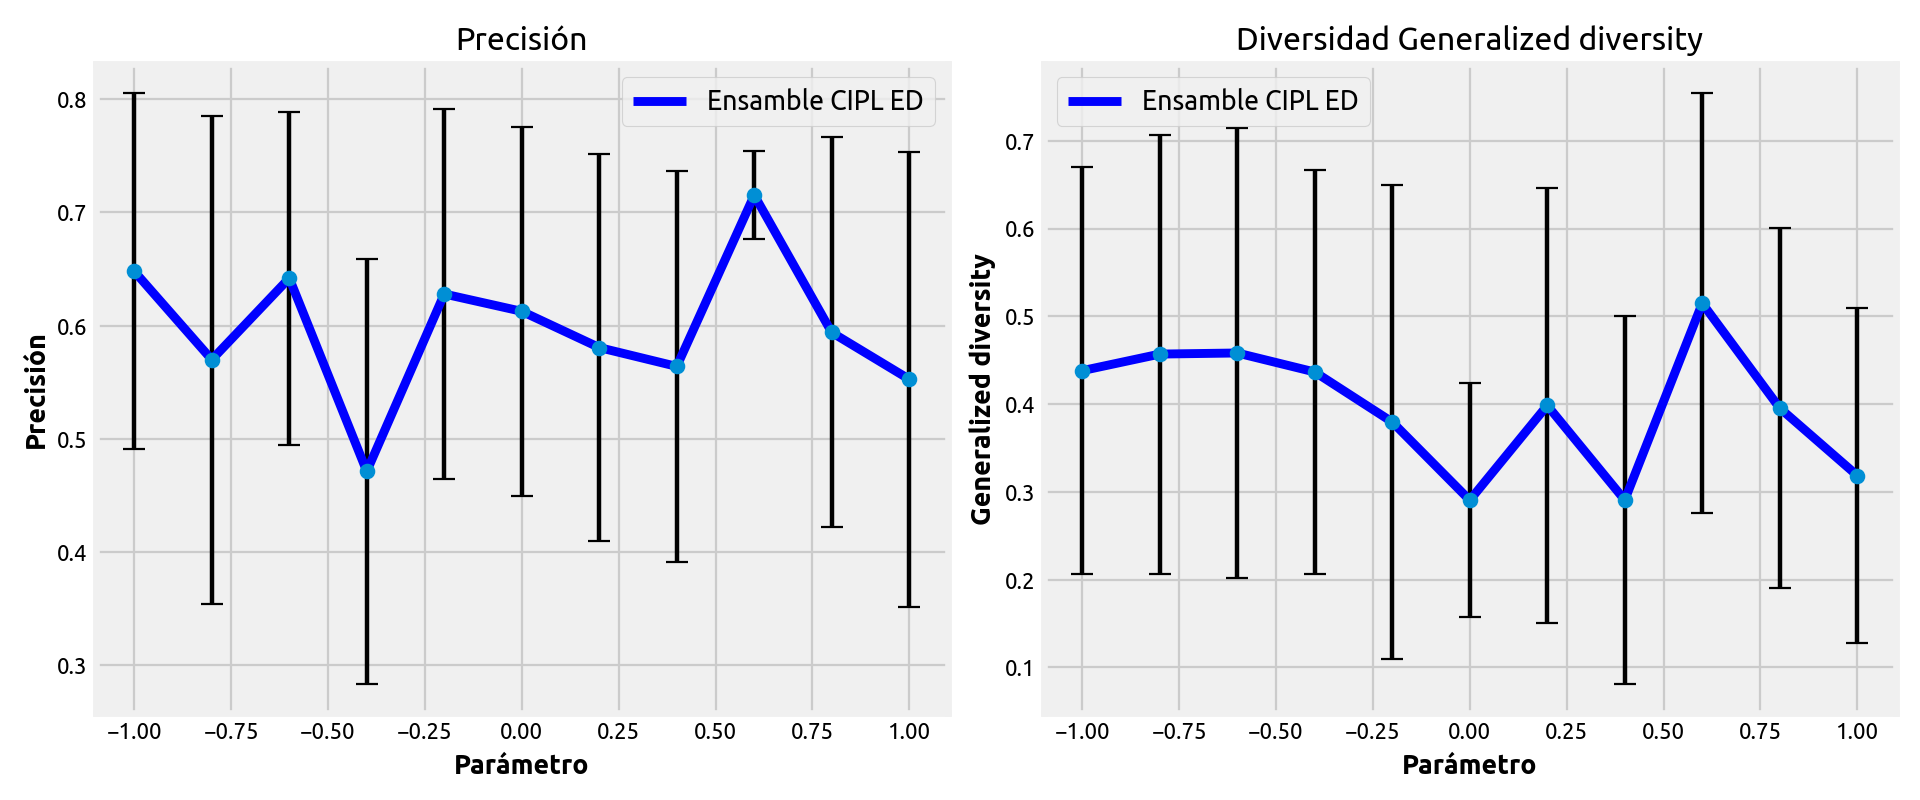

In [20]:
score_cs = np.array(score_cs)
diversity_cs = np.array(diversity_cs)
score_ed = np.array(score_ed)
diversity_ed = np.array(diversity_ed)

f = plt.figure(figsize=(12,5), dpi=80)
plt.subplot(121)
plt.plot(parameters, score_cs[:, 0], 'r',  linestyle='-', label='Ensamble CIPL CS')
plt.errorbar(parameters, score_cs[:, 0], score_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Precisión')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.subplot(122)
plt.plot(parameters, diversity_cs[:, 0], 'r', linestyle='-', label='Ensamble CIPL CS')
plt.errorbar(parameters, diversity_cs[:, 0], diversity_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Diversidad Generalized diversity')
plt.xlabel('Parámetro')
plt.ylabel('Generalized diversity')
plt.tight_layout()

f = plt.figure(figsize=(12,5), dpi=80)
plt.subplot(121)
plt.plot(parameters, score_ed[:, 0], 'b', linestyle='-', label='Ensamble CIPL ED')
plt.errorbar(parameters, score_ed[:, 0], score_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Precisión')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.subplot(122)
plt.plot(parameters, diversity_ed[:, 0], 'b', linestyle='-', label='Ensamble CIPL ED')
plt.errorbar(parameters, diversity_ed[:, 0], diversity_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Diversidad Generalized diversity')
plt.xlabel('Parámetro')
plt.ylabel('Generalized diversity')
plt.tight_layout()

plt.show()